# Predição de Doença Arterial Coronariana com Machine Learning
## I - Importar todas as ferramentas essenciais

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.inspection import permutation_importance

## II - Carregar, ajustar e entender o conjunto de dados
### Mostrar algumas linhas

In [2]:
chd_dataframe = pd.read_csv('SA_heart.csv', index_col = 0)
chd_dataframe.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
id,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


#### A substituição dos valores da variavel 'famhist'  por 0 e 1 vai propiciar o uso de algumas métricas de correlação e encaixe nos modelos de classificação e não causará alteração de valor lógico.

In [3]:
chd_dataframe['famhist'].replace(['Absent', 'Present'], [0, 1], inplace = True)

### Resumir algumas medidas estatísicas das colunas

In [4]:
chd_dataframe.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


#### É notável que não há valores nulos em quaisquer colunas e que a distribuição das variáveis é muito assimétrica.

In [5]:
#preconfigurar aspectos dos plots adiante
sns.set_theme(rc={'figure.figsize':(20,17)}, font_scale = 2)

<AxesSubplot:>

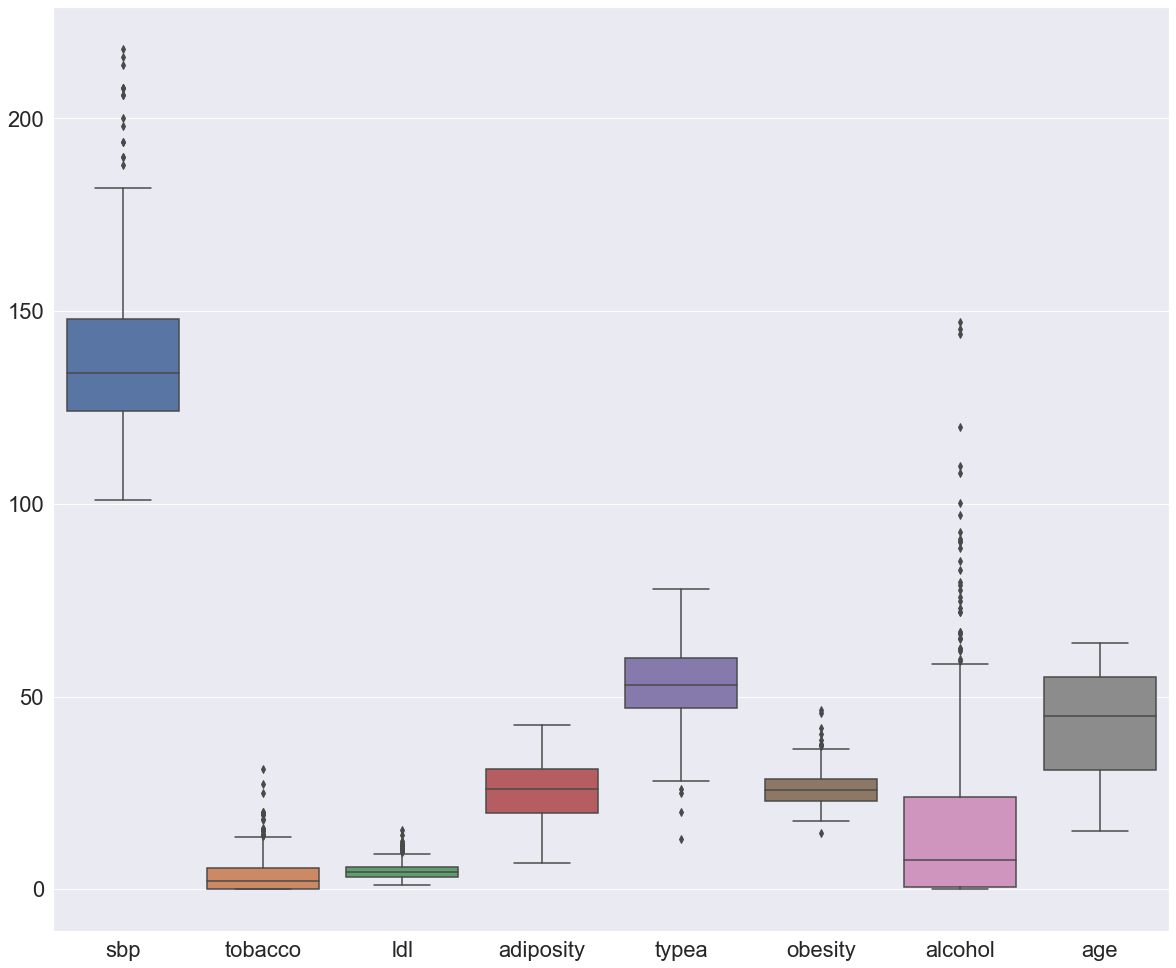

In [6]:
chd_copy = chd_dataframe.copy()
chd_only_num = chd_copy.drop(labels = ["chd", "famhist"], axis = 1)
sns.boxplot(data = chd_only_num)

#### O box-plot mostra que a distribuição dos valores nas colunas é bastante assimétrica e há presença de outliers em vários atributos.

### Correlações entre atributos e variável-alvo

In [7]:
print(chd_dataframe.corr()["chd"].abs().sort_values(ascending=False))


chd          1.000000
age          0.372973
tobacco      0.299718
famhist      0.272373
ldl          0.263053
adiposity    0.254121
sbp          0.192354
typea        0.103156
obesity      0.100095
alcohol      0.062531
Name: chd, dtype: float64


#### A maioria dos atributos possui correlação leve com o alvo, mas 'alcohol' parece ter muito pouca.

### Análise Exploratória dos Dados

<AxesSubplot:xlabel='chd', ylabel='count'>

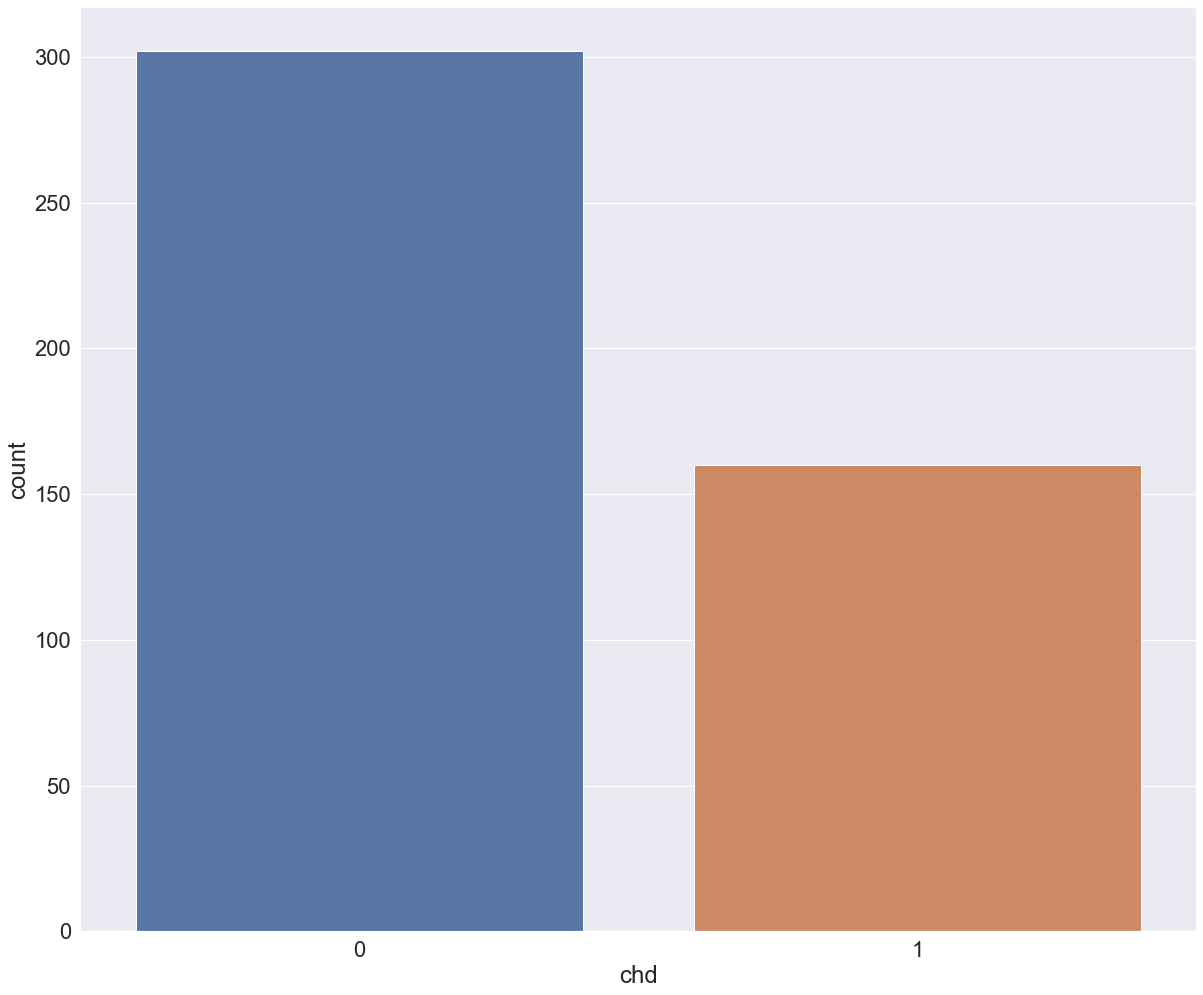

In [8]:
chd_values = chd_dataframe["chd"]

sns.countplot(x = chd_values)

#### Há muito mais pessoas sem a doença do que com a doença nesse conjunto

In [9]:
countNoDisease = len(chd_dataframe[chd_dataframe.chd == 0])
countDisease = len(chd_dataframe[chd_dataframe.chd == 1])
print (f'Porcentagem de pacientes sem chd: {countNoDisease/4.62:.2f}%')
print (f'Porcentagem de pacientes com chd: {countDisease/4.62:.2f}%')

Porcentagem de pacientes sem chd: 65.37%
Porcentagem de pacientes com chd: 34.63%


<AxesSubplot:xlabel='famhist', ylabel='chd'>

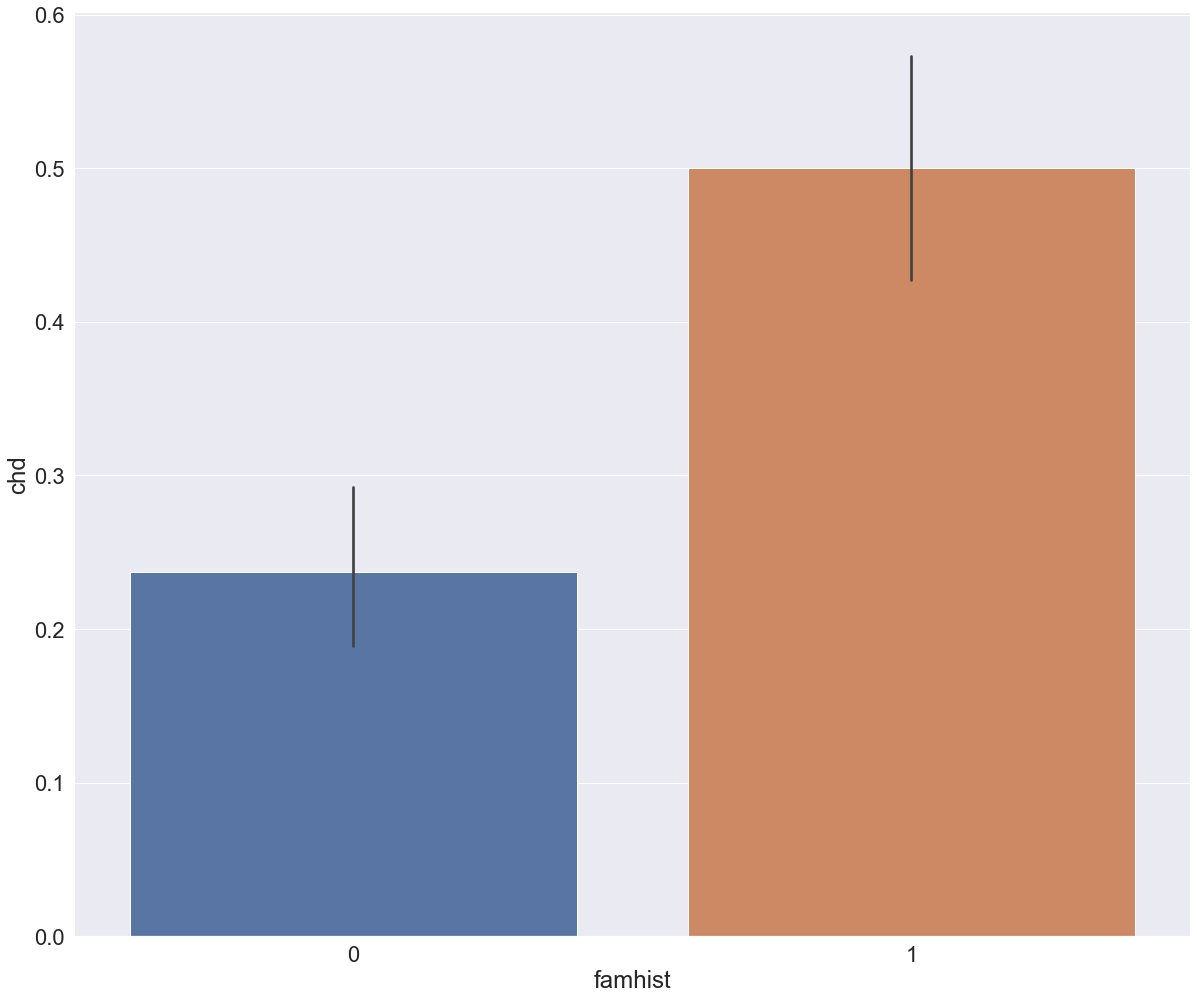

In [10]:
sns.barplot(x = chd_dataframe["famhist"],y = chd_values)

#### Há incidência duas vezes menor da doença nos casos em que não há registro dela na família dos pacientes, do que nos casos em que existem, neste conjunto

## III - Preparação dos dados, encaixe nos modelos e avaliação de performance
### Preparação

In [11]:
#Separar os dados em conjuntos de variáveis preditoras e variável alvo
#Criar uma instância da classe de validação cruzada seguindo o roteiro do trabalho
chd_values = chd_dataframe.values
X = chd_values[:,0:9]
y = chd_values[:,9]
kfold = KFold(n_splits=10)

#### O código para todos os plots a seguir foi retirado da documentação do scikit-learn
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

#### As métricas de avaliação de desempenho consistem na curva ROC, AUC ROC e Matriz de Confusão 

### Classificador Ávore de Decisão

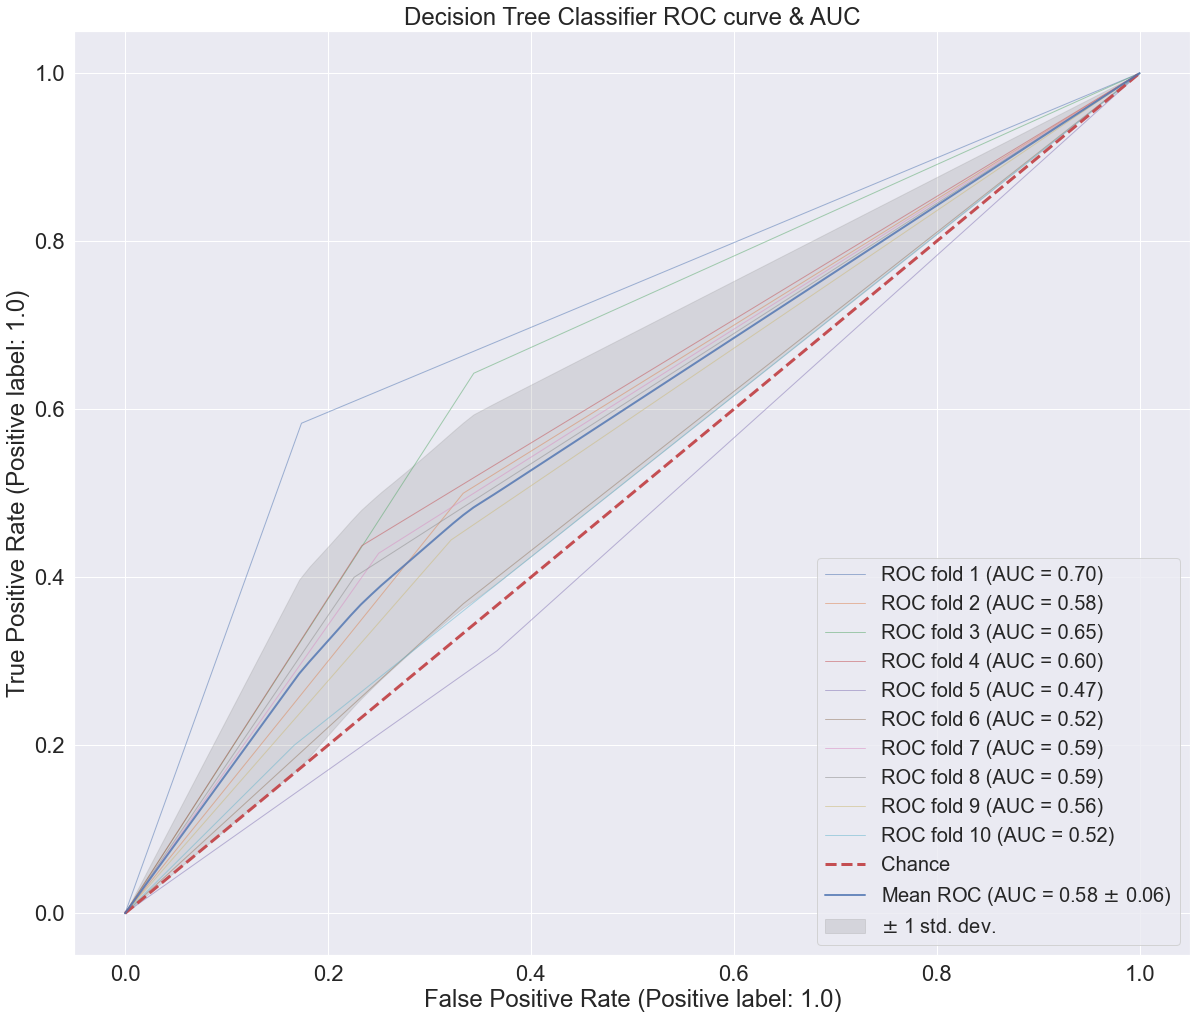

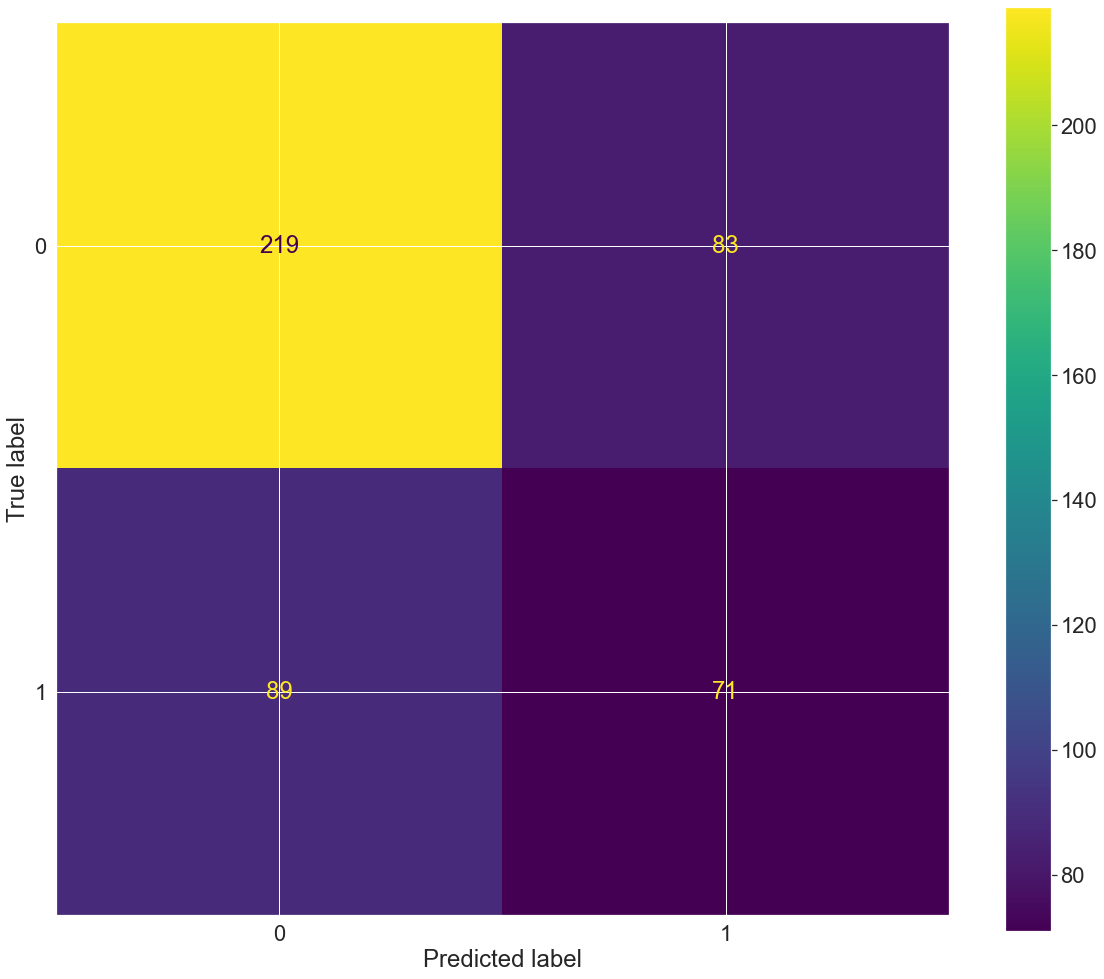

In [12]:
DTC = DecisionTreeClassifier()

tprs = []
aucs = []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

#Para cada rodada da validação, o loop fornece um conjunto de índices para obtenção dos elementos dos conjuntos de treinamento
#Computar a matriz de confusão de todas as vezes e armazenar cada uma em lista
#Do classificador, plotar a curva ROC com os dados de teste, dizer o número da rodada e configurar o gráfico
for i, (train, test) in enumerate(kfold.split(X, y)):
    DTC.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        DTC,
        X[test],
        y[test],
        name="ROC fold {}".format(i+1),
        alpha=0.5,
        lw=1,
        ax=ax,
    )
    #Realizar interpolação linear da função de pontos discretos p = (taxas de falso positivo, taxas de falso negativo)
    #Armazenar o interpolante obtido para plotar a curva ROC média e a ROC AUC para mesmo fim
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    conf_matrices.append(confusion_matrix(y[test], DTC.predict(X[test])))

ax.plot([0, 1], [0, 1], linestyle="--", lw=3, color="r", label="Chance", alpha=1)

#Plotar a curva ROC da média de todos resultados de validação, junto com a AUC e, na legenda, seu desvio padrão
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

#Preencher a figura (em cinza) com uma vez o desvio padrão das interpolações armazenadas, acima e abaixo do valor da ROC média
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

#Ajustar limites dos eixos do gráfico
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Decision Tree Classifier ROC curve & AUC",
)

#Ajustar local e tamanho da legenda
ax.legend(loc="lower right", fontsize = 20)
plt.show()

#Computar a soma dos resultados das matrizes de confusão, elemento a elemento, produzir outra matriz de confusão
el00, el01, el10, el11 = [0,0,0,0]
for matrix in conf_matrices:
    el00 += matrix[0][0] 
    el01 += matrix[0][1]
    el10 += matrix[1][0]
    el11 += matrix[1][1]    
sum_matrix = [el00, el01, el10, el11]
sum_matrix = [[sum_matrix[0], sum_matrix[1]], [sum_matrix[2], sum_matrix[3]]]
disp = ConfusionMatrixDisplay(np.array(sum_matrix))
disp.plot()
plt.show()

#### A primeira figura mostra o a curva ROC de cada rodada da validação cruzada, bem como o valor médio delas. Já a Matriz de Confusão expande a avaliação da figura 1 e mostra também que o modelo desempenhou bem em discernir os falsos negativos dos verdadeiros negativos, apesar de não diferenciar bem falsos positivos de verdadeiros positivos.

### Classificador Florestas Randômicas
#### Considerando todas as variáveis nas ramificações de cada árvore

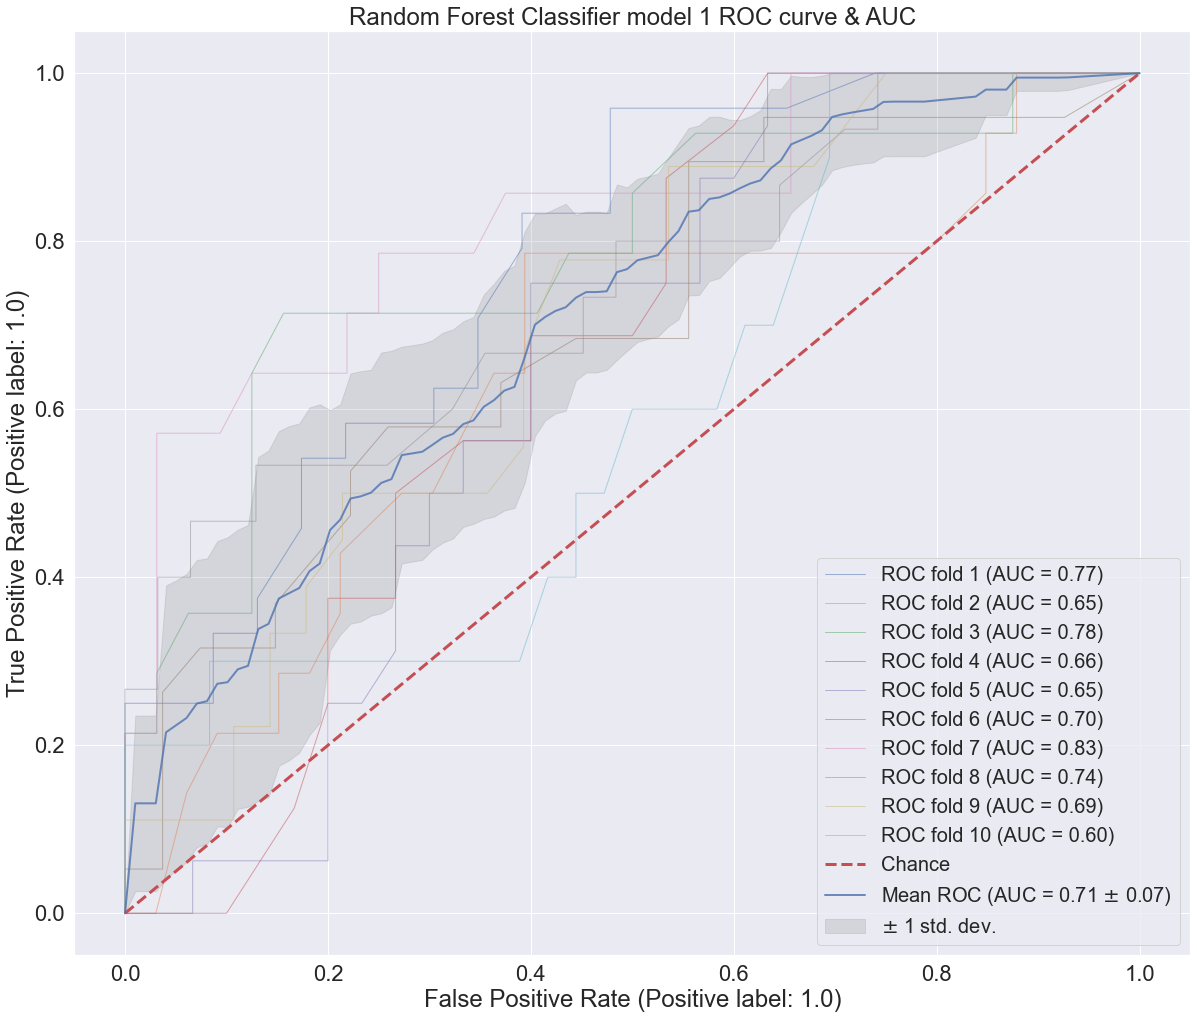

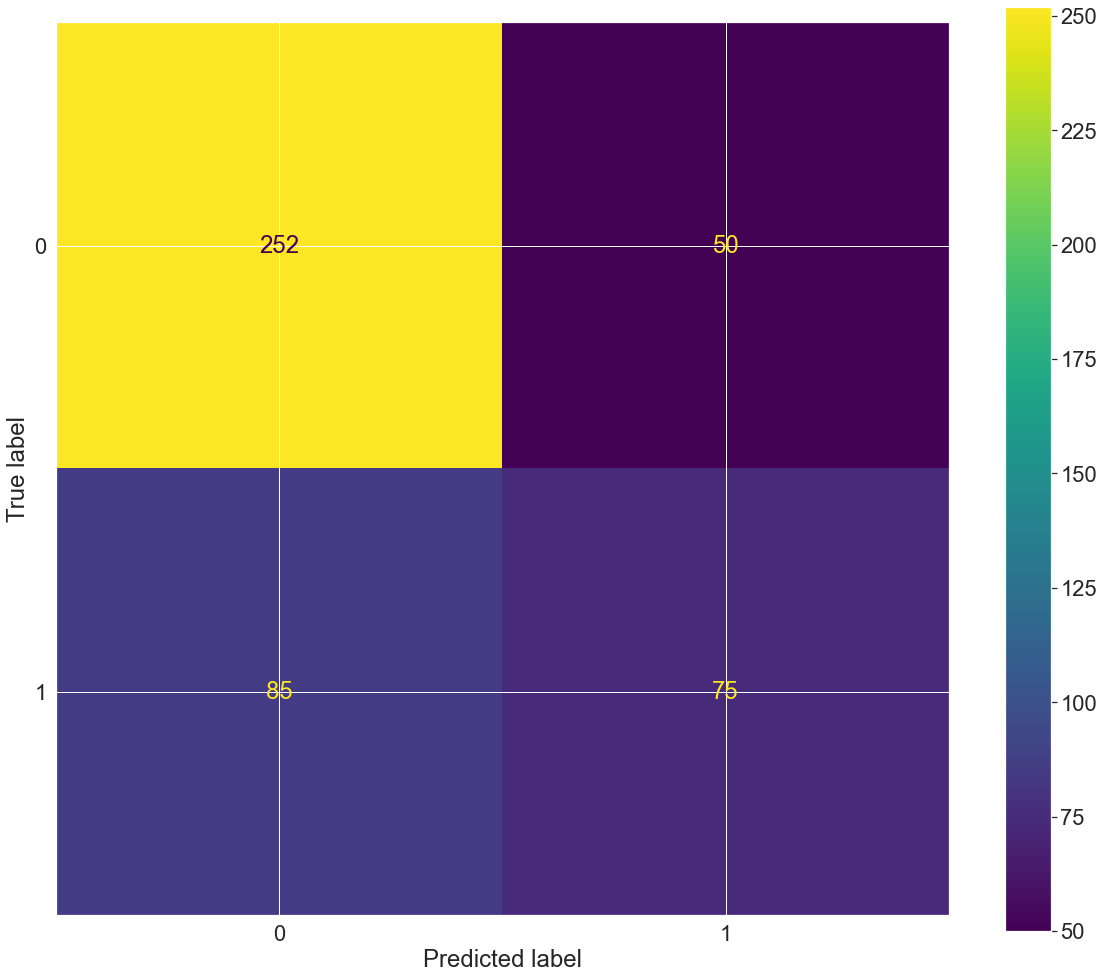

In [13]:
RF1 = RandomForestClassifier(max_features = None)

tprs = []
aucs = []
conf_matrices = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(kfold.split(X, y)):
    RF1.fit(X[train], y[train])
    conf_matrices.append(confusion_matrix(y[test], RF1.predict(X[test])))
    viz = RocCurveDisplay.from_estimator(
        RF1,
        X[test],
        y[test],
        name="ROC fold {}".format(i+1),
        alpha=0.5,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=3, color="r", label="Chance", alpha=1)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Random Forest Classifier model 1 ROC curve & AUC",
)

ax.legend(loc="lower right", fontsize = 20)
plt.show()

el00, el01, el10, el11 = [0,0,0,0]
for matrix in conf_matrices:
    el00 += matrix[0][0] 
    el01 += matrix[0][1]
    el10 += matrix[1][0]
    el11 += matrix[1][1]    
sum_matrix = [el00, el01, el10, el11]
sum_matrix = [[sum_matrix[0], sum_matrix[1]], [sum_matrix[2], sum_matrix[3]]]
disp = ConfusionMatrixDisplay(np.array(sum_matrix))
disp.plot()
plt.show()

#### Aparentemente, houve melhora significativa na taxa de separação entre falsos positivos e verdadeiros positivos, mas não mudou em falsos negativos e verdadeiros negativos.

### Floresta Randômica Padrão

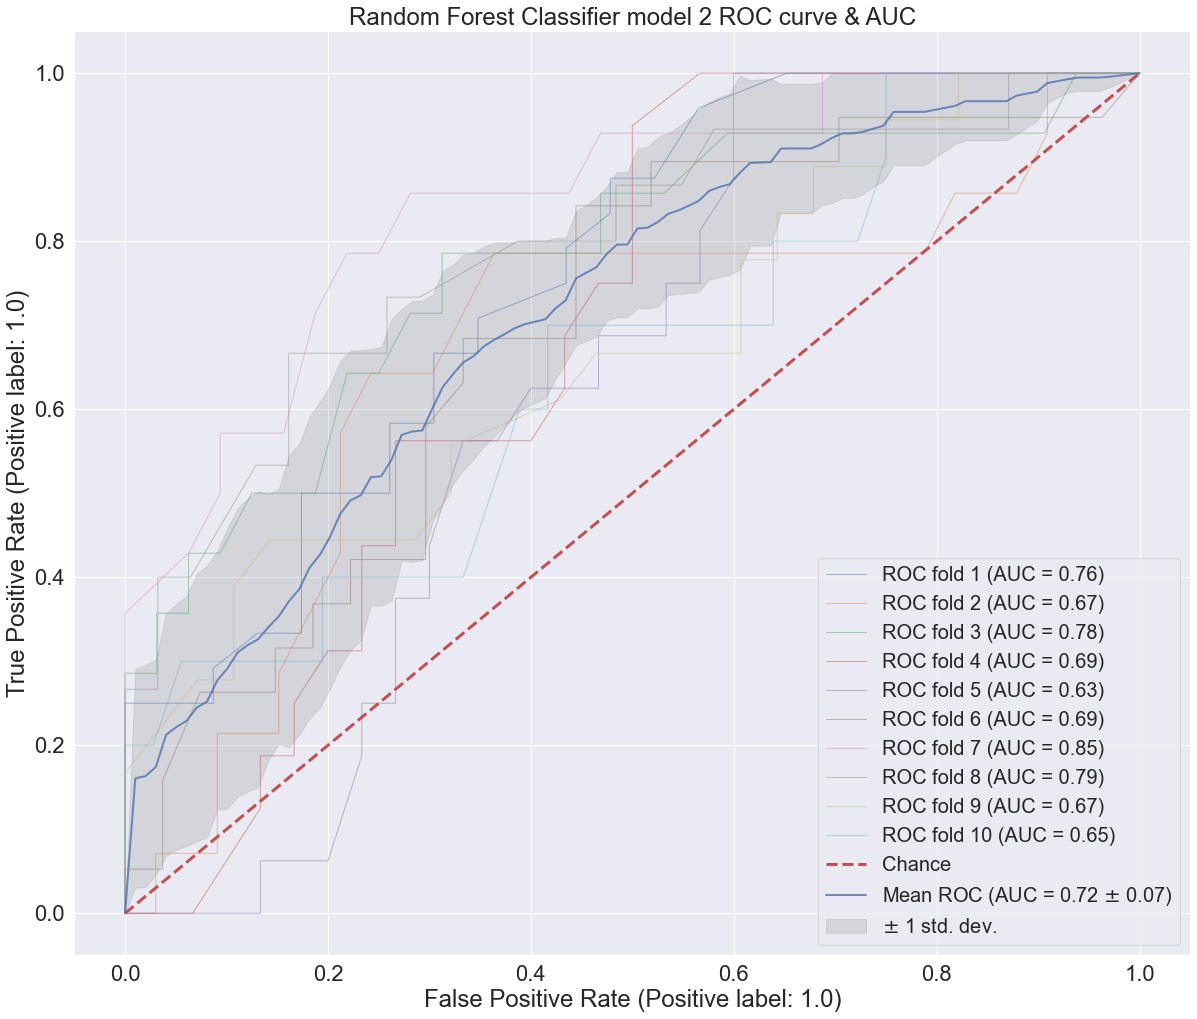

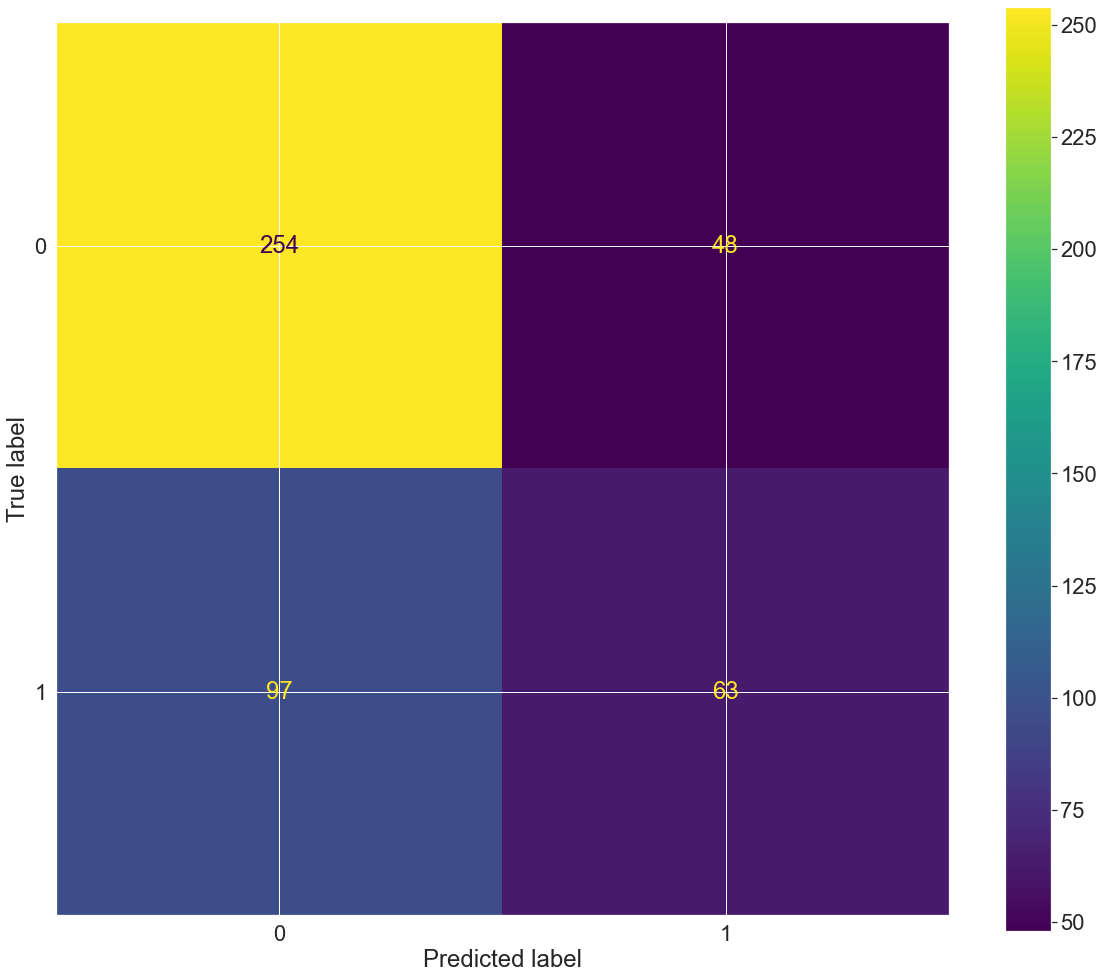

In [14]:
#Deste modelo também extrair as importâncias das variáveis
RF2 = RandomForestClassifier()

tprs = []
aucs = []
conf_matrices = []
importances = []
column_values = list(chd_dataframe.columns.values)[:-1]
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(kfold.split(X, y)):
    RF2.fit(X[train], y[train])
    conf_matrices.append(confusion_matrix(y[test], RF2.predict(X[test])))
    feature_importances = pd.DataFrame(RF2.feature_importances_, index = column_values,
                                     columns=['importance']).sort_values('importance', ascending=False)
    importances.append(feature_importances)
    viz = RocCurveDisplay.from_estimator(
        RF2,
        X[test],
        y[test],
        name="ROC fold {}".format(i+1),
        alpha=0.5,
        lw=1,
        ax=ax,
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=3, color="r", label="Chance", alpha=1)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Random Forest Classifier model 2 ROC curve & AUC",
)

ax.legend(loc="lower right", fontsize = 20)
plt.show()

el00, el01, el10, el11 = [0,0,0,0]
for matrix in conf_matrices:
    el00 += matrix[0][0] 
    el01 += matrix[0][1]
    el10 += matrix[1][0]
    el11 += matrix[1][1]    
sum_matrix = [el00, el01, el10, el11]
sum_matrix = [[sum_matrix[0], sum_matrix[1]], [sum_matrix[2], sum_matrix[3]]]
disp = ConfusionMatrixDisplay(np.array(sum_matrix))
disp.plot()
plt.show()

<AxesSubplot:>

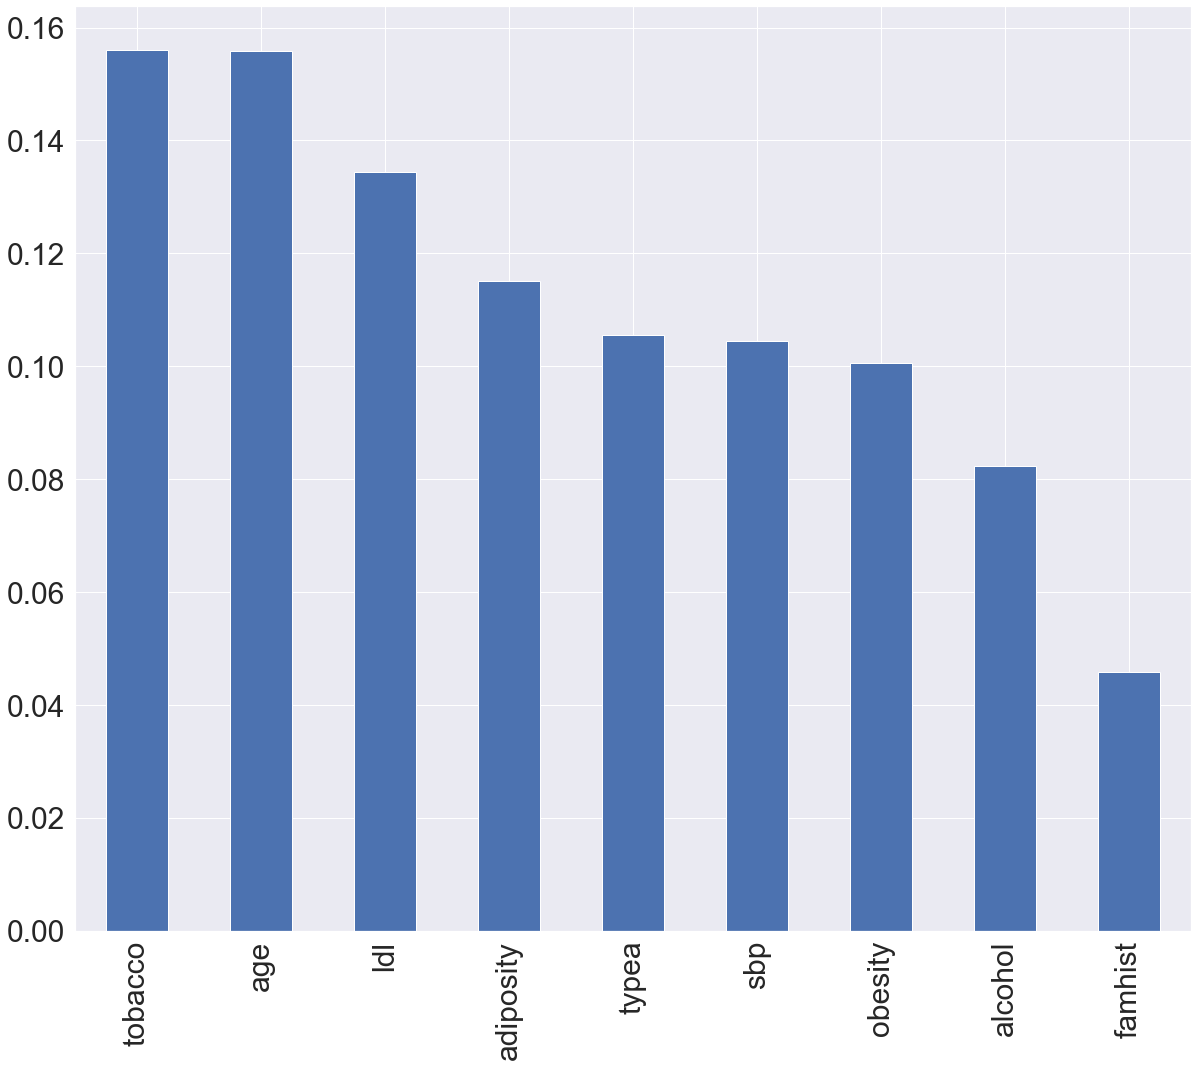

In [15]:
#Concatenar todas as importâncias, tirar a média de cada variável e plotar o gráfico
mean_importance = pd.concat((i for i in importances), axis = 1).mean(axis = 1)
mean_importance.sort_values(ascending = False, inplace = True)
mean_importance.plot(kind = 'bar', fontsize = 30)

#### De acordo com os dados fornecidos pelo modelo 2 de Florestas Randômicas,  as variáveis mais importantes são idade e tabaco, enquanto que as menos importantes são álcool e histórico familiar.